In [1]:
%pip install pandas
%pip install  seaborn==0.13.0
%pip install zss



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import xml.etree.ElementTree as ET
from zss import simple_distance, distance, Node
import numpy as np
import zss
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
print("Seaborn Version: " + sns.__version__)


Seaborn Version: 0.13.0


In [3]:

print(type(sns.color_palette()))
cp = sns.color_palette()
for c in cp:
    rgb = [int(i*255) for i in c]
    print(str(rgb[0])+ ","+ str(rgb[1])+ "," +  str(rgb[2]))

<class 'seaborn.palettes._ColorPalette'>
31,119,180
255,127,14
44,160,44
214,39,40
148,103,189
140,86,75
227,119,194
127,127,127
188,189,34
23,190,207


## ZSS Tree

In [4]:
OR = 0
AND = 1
SAND = 2

class AttackNode(object):

    def __init__(self, label, refinement=OR, children = []):
        self.label = label
        self.refinement = refinement
        self.children = children
        self.depth = -1
        self.position = -1
        self.parent = None
    
    @staticmethod
    def get_children(node):
        return node.children

    @staticmethod
    def get_label(node):
        return node.label

    def get_parent(node):
        return self.parent

    def get_refinement(node):
        return node.refinement

    def set_parents(self):
        for node in self.children:
            node.set_parents()
            node.parent = self

    def get_size(self):
        t_size = 1
        for node in self.children:
            t_size += node.get_size()
        return t_size

    def get_multiset(self):
        if self.children == []:
            return [[self.label]]
        else:
            if self.refinement == OR:
                toReturn = []
                for child in self.children:
                    ms = child.get_multiset()
                    for i in ms:
                        toReturn.append(i)
                return toReturn
            elif self.refinement == AND:
                toReturn = []
                for i in range(len(self.children)):
                    if i == 0:
                        toReturn = [[x[0]] for x in self.children[i].get_multiset()]
                    else:
                        toReturn = [[x[0], y[0]] for x in toReturn for y in self.children[i].get_multiset()]
                        
                return toReturn
            

    def addkid(self, node, before=False):
        node.parent = self
        if before:  
            self.children.insert(0, node)
        else:   
            self.children.append(node)
        return self

    def __str__(self):
        # print(self.refinement, type(self.refinement))
        rest = ""
        if len(self.children) > 0:
            if self.refinement == OR:
                rest = " OR ("
            elif self.refinement == AND:
                rest = " AND ("
            for i in range(len(self.children)):
                rest += str(self.children[i])
                # if isinstance(self.children[i], str):
                #     rest += self.children[i]
                # else :
                #     rest += self.children[i].label
                if i != len(self.children)-1:
                    rest += ", "
            rest += ")"
        return self.label + rest 

    def __eq__(self, other):
        return self.label == other.label and self.refinement == other.refinement and len(self.children) == len(other.children)
        

def xmlToZSSTree(file):
    tree = ET.parse(file)
    root = tree.getroot()[0]
    ZSSTree = XMLZSSNode(root)
    return ZSSTree
    
def XMLZSSNode(node):
    label = node[0].text
    # print(label)
    refinement = node.attrib["refinement"]
    if refinement == "disjunctive":
        refinement = OR
    elif refinement == "conjunctive":
        refinement = AND
    else:
        print(refinement)
        
    children = []
    if len(node) > 1:
        xml_children = node[1:len(node)]
        for i in xml_children:
            children.append(XMLZSSNode(i))
    return AttackNode(label, refinement, children)



def number_tree(root):
    current_depth = 1
    node_dict = {}
    node_dict[current_depth] = []
    depths = [current_depth]

    # Basic BFS on the tree
    node_dict[current_depth].append(root)
    for depth in depths:
        for node in node_dict[depth]:
            if not depth + 1 in node_dict.keys():
                if node.children != []:
                    node_dict[depth + 1] = []
                    if depths[-1] != depth + 1:
                        depths.append(depth + 1)
            for child in node.children:
                node_dict[depth + 1].append(child)

    for depth in node_dict.keys():
        number = 1
        for node in node_dict[depth]:
            node.depth = depth
            node.position = number
            number += 1
    return node_dict


# i = 12
# T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
# tdict = numberTree(T1)
# for key in tdict.keys():
#     for node in tdict[key]:
#         print(node.label, node.depth, node.position)
    
    

    

## Load Stored Data

In [5]:
file_preamble = "PhD/Papers/Attack Tree Edit Distance/code/"
with open(file_preamble + 'pickles/AT1-2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_w_ops', 'rb') as fp:
    at12d1 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1-2_101lims_mk_all-mpnet-base-v2_w_ops', 'rb') as fp:
    at12d2 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1-2_101lims_mk_all-MiniLM-L12-v2_w_ops', 'rb') as fp:
    at12d3 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1-2_101lims_mk_normalized_levenshtein_w_ops', 'rb') as fp:
    at12d4 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1-2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_ld', 'rb') as fp:
    at12e1 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1-2_101lims_mk_all-mpnet-base-v2_ld', 'rb') as fp:
    at12e2 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1-2_101lims_mk_all-MiniLM-L12-v2_ld', 'rb') as fp:
    at12e3 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1-2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_rrd', 'rb') as fp:
    at12f1 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1-2_101lims_mk_all-mpnet-base-v2_rrd', 'rb') as fp:
    at12f2 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1-2_101lims_mk_all-MiniLM-L12-v2_rrd', 'rb') as fp:
    at12f3 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1-2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_ms', 'rb') as fp:
    at12g1 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1-2_101lims_mk_all-mpnet-base-v2_ms', 'rb') as fp:
    at12g2 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1-2_101lims_mk_all-MiniLM-L12-v2_ms', 'rb') as fp:
    at12g3 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1-2_101lims_mk_normalized_levenshtein_multiset', 'rb') as fp:
    at12g4 = pickle.load(fp)


with open(file_preamble + 'pickles/AT2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_w_ops', 'rb') as fp:
    at2d1 = pickle.load(fp)
with open(file_preamble + 'pickles/AT2_101lims_mk_all-mpnet-base-v2_w_ops', 'rb') as fp:
    at2d2 = pickle.load(fp)
with open(file_preamble + 'pickles/AT2_101lims_mk_all-MiniLM-L12-v2_w_ops', 'rb') as fp:
    at2d3 = pickle.load(fp)
with open(file_preamble + 'pickles/AT2_101lims_mk_normalized_levenshtein_w_ops', 'rb') as fp:
    at2d4 = pickle.load(fp)
with open(file_preamble + 'pickles/AT2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_ld', 'rb') as fp:
    at2e1 = pickle.load(fp)
with open(file_preamble + 'pickles/AT2_101lims_mk_all-mpnet-base-v2_ld', 'rb') as fp:
    at2e2 = pickle.load(fp)
with open(file_preamble + 'pickles/AT2_101lims_mk_all-MiniLM-L12-v2_ld', 'rb') as fp:
    at2e3 = pickle.load(fp)
with open(file_preamble + 'pickles/AT2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_rrd', 'rb') as fp:
    at2f1 = pickle.load(fp)
with open(file_preamble + 'pickles/AT2_101lims_mk_all-mpnet-base-v2_rrd', 'rb') as fp:
    at2f2 = pickle.load(fp)
with open(file_preamble + 'pickles/AT2_101lims_mk_all-MiniLM-L12-v2_rrd', 'rb') as fp:
    at2f3 = pickle.load(fp)
with open(file_preamble + 'pickles/AT2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_ms', 'rb') as fp:
    at2g1 = pickle.load(fp)
with open(file_preamble + 'pickles/AT2_101lims_mk_all-mpnet-base-v2_ms', 'rb') as fp:
    at2g2 = pickle.load(fp)
with open(file_preamble + 'pickles/AT2_101lims_mk_all-MiniLM-L12-v2_ms', 'rb') as fp:
    at2g3 = pickle.load(fp)

with open(file_preamble + 'pickles/AT1_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_w_ops', 'rb') as fp:
    d1 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1_101lims_mk_all-mpnet-base-v2_w_ops', 'rb') as fp:
    d2 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1_101lims_mk_all-MiniLM-L12-v2_w_ops', 'rb') as fp:
    d3 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1_101lims_mk_normalized_levenshtein_w_ops', 'rb') as fp:
    d4 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_ld', 'rb') as fp:
    e1 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1_101lims_mk_all-mpnet-base-v2_ld', 'rb') as fp:
    e2 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1_101lims_mk_all-MiniLM-L12-v2_ld', 'rb') as fp:
    e3 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_rrd', 'rb') as fp:
    f1 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1_101lims_mk_all-mpnet-base-v2_rrd', 'rb') as fp:
    f2 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1_101lims_mk_all-MiniLM-L12-v2_rrd', 'rb') as fp:
    f3 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_ms', 'rb') as fp:
    g1 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1_101lims_mk_all-mpnet-base-v2_multiset', 'rb') as fp:
    g2 = pickle.load(fp)
with open(file_preamble + 'pickles/AT1_101lims_mk_all-MiniLM-L12-v2_multiset', 'rb') as fp:
    g3 = pickle.load(fp)

## Create Distance Plots

## Create Operations Plots

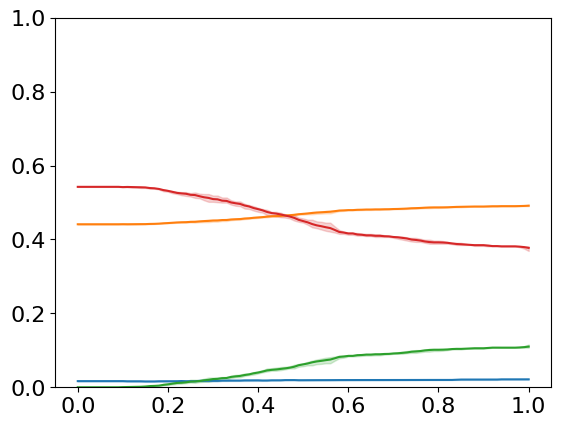

In [6]:

def stat_mappings(mappings):
    dict = {"m":0, "a":0, "r":0, "c":0}
    for m in mappings:
        dict[m[3]] += 1
    dict["c"] = int(dict["c"]/2)
    return dict

def count_operations(ops):
    count = {0:0, 1:0, 2:0, 3:0}
    for op in ops:
        count[op[0]] += 1
    return count


def extract_operations(data, model=None, percentage=False, notzss=True):
    tdf_data = []
    for i in range(0, len(data)):
        row = [data[i][0], model]
        if notzss:
            counts = {"r":0, "a":0, "c":0, "m":0}
        else:
            counts = {0:0, 1:0, 2:0, 3:0}
        for j in range(len(data[i][2])):
            if notzss:
                c = stat_mappings(data[i][2][j][2])
                # Change is double counted in my mappings
                c["c"] /= 2
            else:
                c = count_operations(data[i][2][j][2])
            for k in c.keys():
                counts[k] += c[k]
        if percentage:
            o_sum = 0
            for k in counts.keys():
                o_sum += counts[k] 
            for k in counts.keys():
                counts[k] /= o_sum
        for k in counts.keys():
            row.append(counts[k])
        
            
        tdf_data.append(row)
    df = pd.DataFrame(tdf_data)
    df.columns = ["limit", "Model", "Removal", "Addition", "Change", "Match"]
    return df

def operations_line_data(thedata, percentage=False, notzss=True):
    dfs = []
    for data in thedata:
        dfs.append(extract_operations(data[1], data[0], percentage, notzss))
    return pd.concat(dfs)



#d = ZSS, e = LD, f = RRD, g = MD
# df = operations_line_data([("paraphrase-multilingual-MiniLM-L12", d1), ("all-mpnet-base", d2), ("all-MiniLM-L12", d3)], True, notzss=False)
# df = operations_line_data([("paraphrase-multilingual-MiniLM-L12", e1), ("all-mpnet-base", e2), ("all-MiniLM-L12", e3)])
# df = operations_line_data([("paraphrase-multilingual-MiniLM-L12", f1), ("all-mpnet-base", f2), ("all-MiniLM-L12", f3)], True)
# df = operations_line_data([("paraphrase-multilingual-MiniLM-L12", g1), ("all-mpnet-base", g2), ("all-MiniLM-L12", g3)], True)

df = operations_line_data([("paraphrase-multilingual-MiniLM-L12", at2d1), ("all-mpnet-base", at2d2), ("all-MiniLM-L12", at2d3)], True, notzss=False)

# df = operations_line_data([("paraphrase-multilingual-MiniLM-L12", at2f1), ("all-mpnet-base", at2f2), ("all-MiniLM-L12", at2f3)], True)



# df = operations_line_data([("paraphrase-multilingual-MiniLM-L12", at12f1), ("all-mpnet-base", at12f2), ("all-MiniLM-L12", at12f3)], True)


plot_data = [
             ("zss", "AT1", [("paraphrase-multilingual-MiniLM-L12", d1), ("all-mpnet-base", d2), ("all-MiniLM-L12", d3)]),
             ("zss", "AT2", [("paraphrase-multilingual-MiniLM-L12", at2d1), ("all-mpnet-base", at2d2), ("all-MiniLM-L12", at2d3)]),
             ("zss", "AT1-2", [("paraphrase-multilingual-MiniLM-L12", at12d1), ("all-mpnet-base", at12d2), ("all-MiniLM-L12", at12d3)]),
             ("ld", "AT1", [("paraphrase-multilingual-MiniLM-L12", e1), ("all-mpnet-base", e2), ("all-MiniLM-L12", e3)]),
             ("ld", "AT2", [("paraphrase-multilingual-MiniLM-L12", at2e1), ("all-mpnet-base", at2e2), ("all-MiniLM-L12", at2e3)]),
             ("ld", "AT1-2", [("paraphrase-multilingual-MiniLM-L12", at12e1), ("all-mpnet-base", at12e2), ("all-MiniLM-L12", at12e3)]),
             ("rrd", "AT1", [("paraphrase-multilingual-MiniLM-L12", f1), ("all-mpnet-base", f2), ("all-MiniLM-L12", f3)]),
             ("rrd", "AT2", [("paraphrase-multilingual-MiniLM-L12", at2f1), ("all-mpnet-base", at2f2), ("all-MiniLM-L12", at2f3)]),
             ("rrd", "AT1-2", [("paraphrase-multilingual-MiniLM-L12", at12f1), ("all-mpnet-base", at12f2), ("all-MiniLM-L12", at12f3)]),
             ("ms", "AT1", [("paraphrase-multilingual-MiniLM-L12", g1), ("all-mpnet-base", g2), ("all-MiniLM-L12", g3)]),
             ("ms", "AT2", [("paraphrase-multilingual-MiniLM-L12", at2g1), ("all-mpnet-base", at2g2), ("all-MiniLM-L12", at2g3)]),
             ("ms", "AT1-2", [("paraphrase-multilingual-MiniLM-L12", at12g1), ("all-mpnet-base", at12g2), ("all-MiniLM-L12", at12g3)]),
            ]

for p_d in plot_data:
    df = operations_line_data(p_d[2], True, p_d[0] != "zss") 
    plt.clf()
    plt.ylim(0, 1)

    
    # sns.lineplot(df, x="limit", y ="Removal", label = "Removal")
    # sns.lineplot(df, x="limit", y ="Addition", label = "Addition")
    # sns.lineplot(df, x="limit", y ="Change", label = "Change")
    # sns.lineplot(df, x="limit", y ="Match", label = "Match")
    # plt.xlabel("\nSemantic Similarity Limit (ε)")
    # plt.ylabel("Total number of operations")
    sns.lineplot(df, x="limit", y ="Removal", label = "Removal", legend=False)
    sns.lineplot(df, x="limit", y ="Addition", label = "Addition", legend=False)
    sns.lineplot(df, x="limit", y ="Change", label = "Change", legend=False)
    sns.lineplot(df, x="limit", y ="Match", label = "Match", legend=False)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # plt.title("Effect of rising semantic similarity limit on operation count (" + str(p_d[1]) + ")"    )
    
    plt.savefig(file_preamble + "img/operation_count_" + p_d[0] + "_" + p_d[1] + ".pdf", bbox_inches='tight')

## Single Plots

In [7]:
tree_sizes = {"AT1":{}, "AT2":{}}
for t in ["AT1", "AT2"]:
    for i in range(1, 39):
        if t == "AT2" and ((i == 27) or (i == 28) or (i == 38)):
            continue
        if i < 10:
            i = "0" + str(i)
        T = xmlToZSSTree(file_preamble + "data/" + t + "/ICS2-"+str(i)+".xml")
        tree_sizes[t][int(i)] = T.get_size()

def tree_indexer(number, atype):
    if atype == "AT1":
        number =  number + 1
    else:
        if number < 26:
            number = number + 1
        else:
            number = number + 3
    return number

def extractUnique(tdf, atype = "AT1", percentage=False):
    tdf = tdf.dropna()
    # print(tdf.shape)
    toRet = []
    for i in range(len(tdf)):
        for j in range(i, len(tdf[i])):
            try:
                if percentage:
                    max_size = max(tree_sizes[atype][tree_indexer(i, atype)], tree_sizes[atype][tree_indexer(i, atype)])
                    toRet.append(tdf[i][j]/(1.5*max_size))
                else:
                    toRet.append(tdf[i][j])
            except:
                toRet = toRet

    return toRet




def makeLine(data, atype = "AT1", percentage=True):
    tracker = []
    skip1 = True
    # The data is a list of tuples with (lim, df, operations)
    for thedata in data:
        for k in range(len(thedata[1])):
            # print(thedata[1][k][1])
            # print(pd.DataFrame(thedata[1][k][1]))
        # try:
            unique = extractUnique(pd.DataFrame(thedata[1][k][1]), atype, percentage)
            # print(unique)
            tracker.append((thedata[1][k][0], thedata[0], sum(unique)/len(unique))) 

    tdf = pd.DataFrame(tracker)
    tdf.columns = ["limit", "model", "average distance"]
    return tdf

def makeLineSingle(data, percentage=True):
    tracker = []
    skip1 = True
    # The data is a list of tuples with (lim, df, operations)
    for thedata in data:
        for k in range(len(thedata[1])):
            unique = pd.DataFrame(thedata[1][k][1])
            # print(unique)
            # print(float(unique.sum()))
            if percentage:
                u_sum = 0
                for j in range(len(unique[0])):
                    # print(max(tree_sizes["AT1"][tree_indexer(int(j), "AT1")], tree_sizes["AT2"][tree_indexer(int(j), "AT2")]))
                    u_sum += unique[0][j]/(1.5*max(tree_sizes["AT1"][tree_indexer(int(j), "AT1")], tree_sizes["AT2"][tree_indexer(int(j), "AT2")]))
                comp = u_sum/len(unique)
            else:
                comp = float(unique.sum())/len(unique)
            tracker.append((thedata[1][k][0], thedata[0], comp))
            
    tdf = pd.DataFrame(tracker)
    tdf.columns = ["limit", "model", "average distance"]

    return tdf

In [8]:
# # print(ld2)
# sns.lineplot(ld1, x="limit", y ="average distance", label = "Semantic Comparison")
# # sns.lineplot(ld2, x="limit", y ="average distance", label = "all-mpnet-base-v2")
# # sns.lineplot(ld3, x="limit", y ="average distance", label = "all-MiniLM-L12-v2")
# sns.lineplot(ld4, x="limit", y ="average distance", label = "Normalized Levenshtein")
# sns.lineplot(sldf, x="limit", y ="average distance", label = "Traditional Edit Distance")

# plt.xlabel("\nSemantic Similarity Limit (ε)")
# plt.ylabel("Average Zhang Shasha Distance")
# # plt.xticks(fontsize=8, rotation=90)
# plt.title("Effect of rising semantic similarity limit on average edit distance (AT1)")    

# plt.savefig("img/similaritylimits2_at1.pdf", bbox_inches='tight')

In [9]:
# # print(ld2)
# sns.lineplot(at2ld1, x="limit", y ="average distance", label = "Semantic Comparison")
# # sns.lineplot(ld2, x="limit", y ="average distance", label = "all-mpnet-base-v2")
# # sns.lineplot(ld3, x="limit", y ="average distance", label = "all-MiniLM-L12-v2")
# sns.lineplot(at2ld4, x="limit", y ="average distance", label = "Normalized Levenshtein")
# # sns.lineplot(sldf, x="limit", y ="average distance", label = "Traditional Edit Distance")

# plt.xlabel("\nSemantic Similarity Limit (ε)")
# plt.ylabel("Average Zhang Shasha Distance")
# # plt.xticks(fontsize=8, rotation=90)
# plt.title("Effect of rising semantic similarity limit on average edit distance (AT2)")    

# plt.savefig("img/similaritylimits2_at2.pdf", bbox_inches='tight')

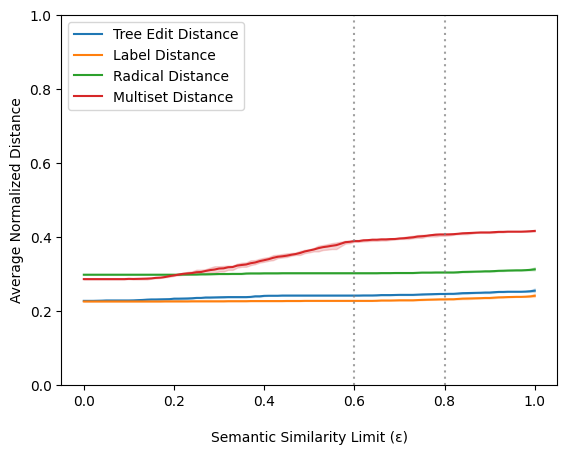

In [10]:
percentage = True

at12ld1 = makeLineSingle([("paraphrase-multilingual-MiniLM-L12", at12d1), ("all-mpnet-base", at12d2), ("all-MiniLM-L12", at12d3)], percentage)
at12ld2 = makeLineSingle([("paraphrase-multilingual-MiniLM-L12", at12e1), ("all-mpnet-base", at12e2), ("all-MiniLM-L12", at12e3)], percentage)
at12ld3 = makeLineSingle([("paraphrase-multilingual-MiniLM-L12", at12f1), ("all-mpnet-base", at12f2), ("all-MiniLM-L12", at12f3)], percentage)
at12ld4 = makeLineSingle([("paraphrase-multilingual-MiniLM-L12", at12g1), ("all-mpnet-base", at12g2), ("all-MiniLM-L12", at12g3)], percentage)

filename = "similaritylimits_at1-2"
if percentage:
    filename += "_percentage"

sns.lineplot(at12ld1, x="limit", y ="average distance", label = "Tree Edit Distance")
# sns.lineplot(ld2, x="limit", y ="average distance", label = "all-mpnet-base-v2")
# sns.lineplot(ld3, x="limit", y ="average distance", label = "all-MiniLM-L12-v2")
# sns.lineplot(at12ld4, x="limit", y ="average distance", label = "Normalized Levenshtein")
sns.lineplot(at12ld2, x="limit", y ="average distance", label = "Label Distance")
sns.lineplot(at12ld3, x="limit", y ="average distance", label = "Radical Distance")
sns.lineplot(at12ld4, x="limit", y ="average distance", label = "Multiset Distance")
# sns.lineplot(sldf, x="limit", y ="average distance", label = "Traditional Edit Distance")

plt.xlabel("\nSemantic Similarity Limit (ε)")
if percentage:
    plt.ylim(0, 1)
    plt.ylabel("Average Normalized Distance")
else:
    plt.ylabel("Average Distance")
# plt.xticks(fontsize=8, rotation=90)
# plt.title("Effect of rising semantic similarity limit on average edit distance (AT1 vs AT2)") 
plt.axvline(.6, 0,1, color="gray", dashes=(1,2), alpha = .75)
plt.axvline(.8, 0,1, color="gray", dashes=(1,2), alpha = .75)

plt.savefig(file_preamble + "img/"+filename+".pdf", bbox_inches='tight')

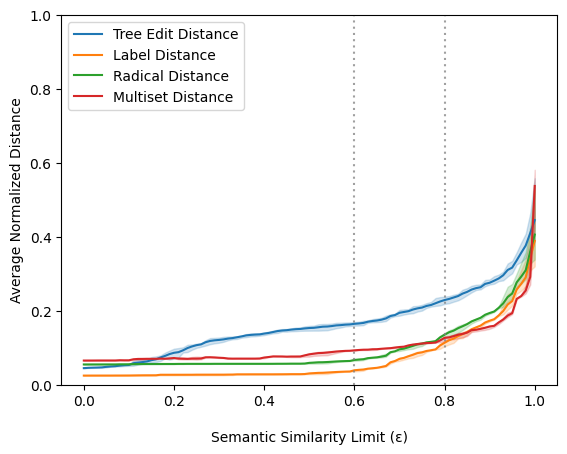

In [20]:
# percentage = False
ld1 = makeLine([("paraphrase-multilingual-MiniLM-L12", d1), ("all-mpnet-base", d2), ("all-MiniLM-L12", d3)], "AT1", percentage)
ld2 = makeLine([("paraphrase-multilingual-MiniLM-L12", e1), ("all-mpnet-base", e2), ("all-MiniLM-L12", e3)], "AT1", percentage)
ld3 = makeLine([("paraphrase-multilingual-MiniLM-L12", f1), ("all-mpnet-base", f2), ("all-MiniLM-L12", f3)], "AT1", percentage)
ld4 = makeLine([("paraphrase-multilingual-MiniLM-L12", g1), ("all-mpnet-base", g2), ("all-MiniLM-L12", g3)], "AT1", percentage)
fullLineat1 = makeLine([("paraphrase-multilingual-MiniLM-L12", d1), ("all-mpnet-base", d2), ("all-MiniLM-L12", d3),("paraphrase-multilingual-MiniLM-L12", e1), ("all-mpnet-base", at2e2), ("all-MiniLM-L12", e3), ("paraphrase-multilingual-MiniLM-L12", f1), ("all-mpnet-base", f2), ("all-MiniLM-L12", f3),("paraphrase-multilingual-MiniLM-L12", g1),("all-mpnet-base", g2), ("all-MiniLM-L12", g3)], "AT1", percentage)

filename = "similaritylimits_at1"
if percentage:
    filename += "_percentage"


# sns.lineplot(data=fullLineat1, x="limit", y="average distance", color="gray", alpha=.15, dashes=(1,1))
sns.lineplot(ld1, x="limit", y ="average distance", label = "Tree Edit Distance")
sns.lineplot(ld2, x="limit", y ="average distance", label = "Label Distance")
sns.lineplot(ld3, x="limit", y ="average distance", label = "Radical Distance")
sns.lineplot(ld4, x="limit", y ="average distance", label = "Multiset Distance")
# sns.lineplot(ld2, x="limit", y ="average distance", label = "all-mpnet-base-v2")
# sns.lineplot(ld3, x="limit", y ="average distance", label = "all-MiniLM-L12-v2")
# sns.lineplot(ld4, x="limit", y ="average distance", label = "Normalized Levenshtein")
# sns.lineplot(sldf, x="limit", y ="average distance", label = "Traditional Edit Distance")

plt.xlabel("\nSemantic Similarity Limit (ε)")
if percentage:
    plt.ylim(0, 1)
    plt.ylabel("Average Normalized Distance")
else:
    plt.ylabel("Average Distance")
plt.axvline(.6, 0,1, color="gray", dashes=(1,2), alpha = .75)
plt.axvline(.8, 0,1, color="gray", dashes=(1,2), alpha = .75)
# plt.xticks(fontsize=8, rotation=90)
# plt.title("Effect of rising semantic similarity limit on average distance (AT1)")    

plt.savefig(file_preamble + "img/"+filename+".pdf", bbox_inches='tight')

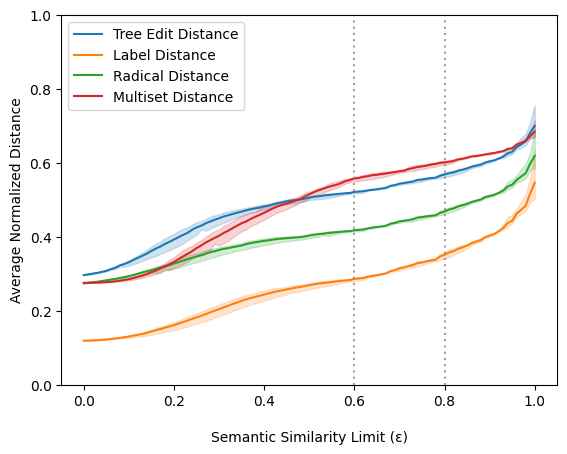

In [19]:
# percentage = True

at2ld1 = makeLine([("paraphrase-multilingual-MiniLM-L12", at2d1), ("all-mpnet-base", at2d2), ("all-MiniLM-L12", at2d3)], "AT2", percentage)
at2ld2 = makeLine([("paraphrase-multilingual-MiniLM-L12", at2e1), ("all-mpnet-base", at2e2), ("all-MiniLM-L12", at2e3)], "AT2", percentage)
at2ld3 = makeLine([("paraphrase-multilingual-MiniLM-L12", at2f1), ("all-mpnet-base", at2f2), ("all-MiniLM-L12", at2f3)], "AT2", percentage)
at2ld4 = makeLine([("paraphrase-multilingual-MiniLM-L12", at2g1),("all-mpnet-base", at2g2), ("all-MiniLM-L12", at2g3)], "AT2", percentage)
fullLine = makeLine([("paraphrase-multilingual-MiniLM-L12", at2d1), ("all-mpnet-base", at2d2), ("all-MiniLM-L12", at2d3),("paraphrase-multilingual-MiniLM-L12", at2e1), ("all-mpnet-base", at2e2), ("all-MiniLM-L12", at2e3), ("paraphrase-multilingual-MiniLM-L12", at2f1), ("all-mpnet-base", at2f2), ("all-MiniLM-L12", at2f3),("paraphrase-multilingual-MiniLM-L12", at2g1),("all-mpnet-base", at2g2), ("all-MiniLM-L12", at2g3)], "AT2", percentage)

filename = "similaritylimits_at2"
if percentage:
    filename += "_percentage"

# sns.lineplot(data=fullLine, x="limit", y="average distance", color="gray", alpha=.15, dashes=(1,1))
sns.lineplot(at2ld1, x="limit", y ="average distance", label = "Tree Edit Distance")
sns.lineplot(at2ld2, x="limit", y ="average distance", label = "Label Distance")
sns.lineplot(at2ld3, x="limit", y ="average distance", label = "Radical Distance")
sns.lineplot(at2ld4, x="limit", y ="average distance", label = "Multiset Distance")
# sns.lineplot(ld2, x="limit", y ="average distance", label = "all-mpnet-base-v2")
# sns.lineplot(ld3, x="limit", y ="average distance", label = "all-MiniLM-L12-v2")
# sns.lineplot(ld4, x="limit", y ="average distance", label = "Normalized Levenshtein")
# sns.lineplot(sldf, x="limit", y ="average distance", label = "Traditional Edit Distance")

plt.axvline(.6, 0,1, color="gray", dashes=(1,2), alpha = .75)
plt.axvline(.8, 0,1, color="gray", dashes=(1,2), alpha = .75)

plt.xlabel("\nSemantic Similarity Limit (ε)")
if percentage:
    plt.ylim(0, 1)
    plt.ylabel("Average Normalized Distance")
else:
    plt.ylabel("Average Distance")
# plt.xticks(fontsize=8, rotation=90)
# plt.title("Effect of rising semantic similarity limit on average distance (AT2)")    

plt.savefig(file_preamble + "img/"+filename+".pdf", bbox_inches='tight')

In [13]:
# Scatter

# Weighted Sum Distance

In [41]:
# print(d1[0][1],d1[0][1].values.tolist())
# print(type(d1))
def makeWSD(dists, weights):
    data = []
    # print(type(dists), type(dists[0]))
    # for lim_i in range(0, 2):
    for lim_i in range(0, len(dists[0])):
        dfs = []
        for d in dists:
            dfs.append(d[lim_i][1].values.tolist())
        l_data = []
        for i in range(0, len(dfs[0])):
            col = []
            for j in range(0, len(dfs[0][0])):
                val = 0
                for k in range(0, len(dfs)):
                    val += dfs[k][i][j]*weights[k]
                col.append(val)
            l_data.append(col)
        data.append((dists[0][lim_i][0], pd.DataFrame(l_data)))
    return data

lbs = [.25, .5, .25, 0]
h1_4240 = makeWSD([d1, e1, f1, g1], lbs)
h2_4240 = makeWSD([d2, e2, f2, g2], lbs)
h3_4240 = makeWSD([d3, e3, f3, g3], lbs)
h1at2_4240 = makeWSD([at2d1, at2e1, at2f1, at2g1], lbs)
h2at2_4240 = makeWSD([at2d2, at2e2, at2f2, at2g2], lbs)
h3at2_4240 = makeWSD([at2d3, at2e3, at2f3, at2g3], lbs)
# h1at12_4240 = makeWSD([at12d1, at12e1, at12f1, at12g1], lbs)
# h2at12_4240 = makeWSD([at12d2, at12e2, at12f2, at12g2], lbs)
# h3at12_4240 = makeWSD([at12d3, at12e3, at12f3, at12g3], lbs)
lbs = [.25, .25, .25, .25]
h1_4444 = makeWSD([d1, e1, f1, g1], lbs)
h2_4444 = makeWSD([d2, e2, f2, g2], lbs)
h3_4444 = makeWSD([d3, e3, f3, g3], lbs)
lbs = [.75, .125, .125, 0]
h1_3880 = makeWSD([d1, e1, f1, g1], lbs)
h2_3880 = makeWSD([d2, e2, f2, g2], lbs)
h3_3880 = makeWSD([d3, e3, f3, g3], lbs)






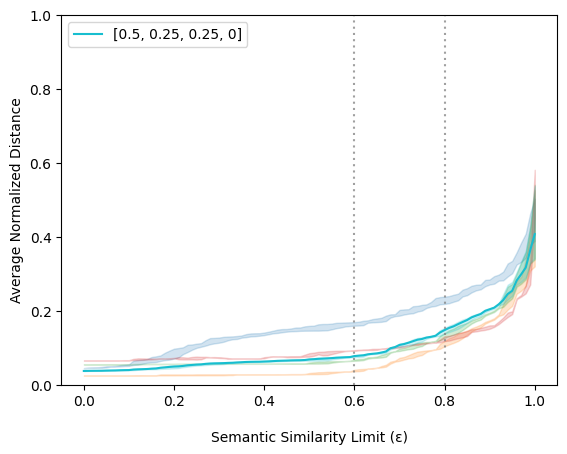

In [46]:
lh1_4240 = makeLine([("paraphrase-multilingual-MiniLM-L12", h1_4240), ("all-mpnet-base", h2_4240), ("all-MiniLM-L12", h3_4240)], "AT1", percentage)
lh1_4444 = makeLine([("paraphrase-multilingual-MiniLM-L12", h1_4444), ("all-mpnet-base", h2_4444), ("all-MiniLM-L12", h3_4444)], "AT1", percentage)
lh1_3880 = makeLine([("paraphrase-multilingual-MiniLM-L12", h1_3880), ("all-mpnet-base", h2_3880), ("all-MiniLM-L12", h3_3880)], "AT1", percentage)



filename = "wsd-at1"
old_line = .001
sns.lineplot(ld1, x="limit", y ="average distance", alpha=old_line, dashes=(1,3))
sns.lineplot(ld2, x="limit", y ="average distance", alpha=old_line, dashes=(1,3))
sns.lineplot(ld3, x="limit", y ="average distance", alpha=old_line, dashes=(1,3))
sns.lineplot(ld4, x="limit", y ="average distance", alpha=old_line, dashes=(1,3))
sns.lineplot(lh1_4240, x="limit", y ="average distance", label = "[0.5, 0.25, 0.25, 0]", color=sns.color_palette()[9], linewidth=1.5)
# sns.lineplot(lh1_4444, x="limit", y ="average distance", label = "[0.25, 0.25, 0.25, 0.25]", color=sns.color_palette()[5])
# sns.lineplot(lh1_3880, x="limit", y ="average distance", label = "[0.75, 0.125, 0.125, 0]", color=sns.color_palette()[6])

# sns.lineplot(ld2, x="limit", y ="average distance", label = "all-mpnet-base-v2")
# sns.lineplot(ld3, x="limit", y ="average distance", label = "all-MiniLM-L12-v2")
# sns.lineplot(ld4, x="limit", y ="average distance", label = "Normalized Levenshtein")
# sns.lineplot(sldf, x="limit", y ="average distance", label = "Traditional Edit Distance")

plt.axvline(.6, 0,1, color="gray", dashes=(1,2), alpha = .75)
plt.axvline(.8, 0,1, color="gray", dashes=(1,2), alpha = .75)

plt.xlabel("\nSemantic Similarity Limit (ε)")
if percentage:
    plt.ylim(0, 1)
    plt.ylabel("Average Normalized Distance")
else:
    plt.ylabel("Average Distance")
# plt.xticks(fontsize=8, rotation=90)
# plt.title("Effect of rising semantic similarity limit on average distance (AT2)")    

plt.savefig(file_preamble + "img/"+filename+".pdf", bbox_inches='tight')

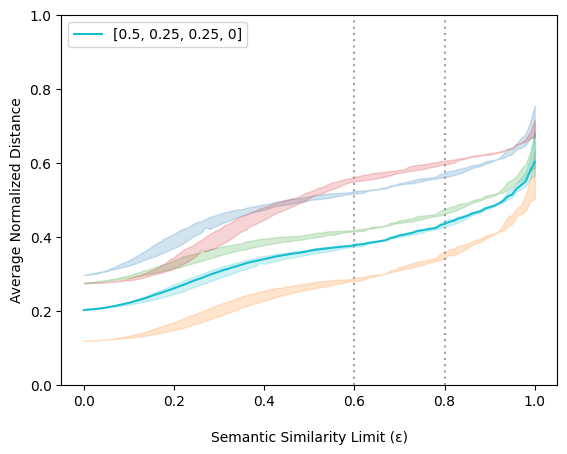

In [47]:
lh1at2_4240 = makeLine([("paraphrase-multilingual-MiniLM-L12", h1at2_4240), ("all-mpnet-base", h2at2_4240), ("all-MiniLM-L12", h3at2_4240)], "AT2", percentage)

filename = "wsd-at2"
sns.lineplot(at2ld1, x="limit", y ="average distance", alpha=old_line, dashes=(1,3))
sns.lineplot(at2ld2, x="limit", y ="average distance", alpha=old_line, dashes=(1,3))
sns.lineplot(at2ld3, x="limit", y ="average distance", alpha=old_line, dashes=(1,3))
sns.lineplot(at2ld4, x="limit", y ="average distance", alpha=old_line, dashes=(1,3))
sns.lineplot(lh1at2_4240, x="limit", y ="average distance", label = "[0.5, 0.25, 0.25, 0]", color=sns.color_palette()[9], linewidth=1.5)
# sns.lineplot(lh1_4444, x="limit", y ="average distance", label = "[0.25, 0.25, 0.25, 0.25]", color=sns.color_palette()[5])
# sns.lineplot(lh1_3880, x="limit", y ="average distance", label = "[0.75, 0.125, 0.125, 0]", color=sns.color_palette()[6])

# sns.lineplot(ld2, x="limit", y ="average distance", label = "all-mpnet-base-v2")
# sns.lineplot(ld3, x="limit", y ="average distance", label = "all-MiniLM-L12-v2")
# sns.lineplot(ld4, x="limit", y ="average distance", label = "Normalized Levenshtein")
# sns.lineplot(sldf, x="limit", y ="average distance", label = "Traditional Edit Distance")

plt.axvline(.6, 0,1, color="gray", dashes=(1,2), alpha = .75)
plt.axvline(.8, 0,1, color="gray", dashes=(1,2), alpha = .75)

plt.xlabel("\nSemantic Similarity Limit (ε)")
if percentage:
    plt.ylim(0, 1)
    plt.ylabel("Average Normalized Distance")
else:
    plt.ylabel("Average Distance")
# plt.xticks(fontsize=8, rotation=90)
# plt.title("Effect of rising semantic similarity limit on average distance (AT2)")    

plt.savefig(file_preamble + "img/"+filename+".pdf", bbox_inches='tight')

## Determining Optimal Alpha

In [62]:
alphas = [0, 0, 0, 0]


def alphaDist(alpha):
    incorrect = 0
    dist = 0
    if alpha[1]*7 != 0:
        incorrect += 1
        dist += abs(alpha[1]*7)
    if alpha[1] + alpha[2] + 3*alpha[3] != 1:
        incorrect += 1
        dist += abs(alpha[1] + alpha[2] + 3*alpha[3] - 1)
    if alpha[0] + alpha[1] + alpha[2] != 1:
        incorrect += 3
        dist += 3*abs(alpha[0] + alpha[1] + alpha[2] - 1)
    if alpha[0] + alpha[1] + 4*alpha[2] != 1:
        incorrect += 1
        dist += abs(alpha[0] + alpha[1] + 4*alpha[2] - 1)
    if alpha[0] + alpha[1] + alpha[2] + alpha[3] != 1:
        incorrect += 3
        dist += 3*abs(alpha[0] + alpha[1] + alpha[2] + alpha[3] - 1)
    if 2*alpha[1] + 2*alpha[2] + 3 * alpha[3] != 1:
        incorrect += 1
        dist += abs(2*alpha[1] + 2*alpha[2] + 3 * alpha[3] - 1)
    if 2*alpha[1] + 2*alpha[2] != 1:
        incorrect += 1
        dist += abs(2*alpha[1] + 2*alpha[2]  - 1)
    if 2*alpha[1] + 3*alpha[2] +  alpha[3] != 1:
        incorrect += 1
        dist += abs(2*alpha[1] + 3*alpha[2] +  alpha[3] - 1)
    return incorrect, dist

print(alphaDist([.5, .25, .25, 0]))
if True:
    alpha_dists2 = []
    for a in range(0, 101, 5):
        a = a/100
        for b in range(0, 101, 5):
            b = b/100
            for c in range(0, 101, 5):
                c = c/100
                for d in range(0, 101, 5):
                    # print(a, b, c, d)
                    d = d/100
                    row = [a, b, c, d]
                    a_i, a_dists = alphaDist(row)
                    row.append(a_i)
                    row.append(a_dists)
                    alpha_dists2.append(row)
alpha_df = pd.DataFrame(data=alpha_dists2, columns=["LD", "TED", "RD", "MSD", "incorrect", "distance"])


(4, 3.25)


In [73]:
print(alpha_df.sort_values(by="incorrect"))

          LD   TED    RD   MSD  incorrect  distance
97020   0.50  0.50  0.00  0.00          2      4.00
92820   0.50  0.00  0.50  0.00          3      2.50
420     0.00  0.00  1.00  0.00          4      7.00
94920   0.50  0.25  0.25  0.00          4      3.25
94080   0.50  0.15  0.35  0.00          4      2.95
...      ...   ...   ...   ...        ...       ...
70288   0.35  0.60  0.40  0.05         12     11.75
70289   0.35  0.60  0.40  0.10         12     12.25
70290   0.35  0.60  0.40  0.15         12     12.75
70402   0.35  0.60  0.65  0.50         12     20.75
194480  1.00  1.00  1.00  1.00         12     45.00

[194481 rows x 6 columns]


In [71]:
alpha = [0.5, 0.15, 0.35, 0]
the_rows = [[0, 7, 0, 0], [0, 1, 1, 3], [1, 1, 1, 0], [1, 1, 4, 0], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 0], [1, 1, 1, 0], [1, 1, 1, 1], [0, 2, 2, 3], [0, 2, 2, 0], [0, 2, 3, 1]]
for row in the_rows:
    sum = 0
    for i in range(0, 4, 1):
        sum += alpha[i] * row[i]
    print(sum)

1.05
0.5
1.0
2.05
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.3499999999999999


# Scatter

In [35]:
def makeScatter(data, dmeasure, atype = "AT1", percentage=True):
    tracker = []
    skip1 = True
    # The data is a list of tuples with (lim, df, operations)
    for thedata in data:
        for k in range(len(thedata[1])):
            # print(thedata[1][k][1])
            # print(pd.DataFrame(thedata[1][k][1]))
        # try:
            unique = extractUnique(pd.DataFrame(thedata[1][k][1]), atype, percentage)
            
            # print(unique)
            for d in unique:
                if d > 0:
                    tracker.append((thedata[1][k][0], thedata[0], dmeasure, d)) 
    tdf = pd.DataFrame(tracker)
    tdf.columns = ["limit", "model", "distance measure", "average distance"]
    return tdf

# print(type(at2d1[1][1].columns))

# print(makeScatter([("paraphrase-multilingual-MiniLM-L12", at2d1), ("all-mpnet-base", at2d2), ("all-MiniLM-L12", at2d3)]))
percentage = True
at2sd1 = makeScatter([("paraphrase-multilingual-MiniLM-L12", at2d1), ("all-mpnet-base", at2d2), ("all-MiniLM-L12", at2d3)], "Tree Edit Distance", "AT2", percentage)
at2sd2 = makeScatter([("paraphrase-multilingual-MiniLM-L12", at2e1), ("all-mpnet-base", at2e2), ("all-MiniLM-L12", at2e3)], "Label Distance", "AT2", percentage)
at2sd3 = makeScatter([("paraphrase-multilingual-MiniLM-L12", at2f1), ("all-mpnet-base", at2f2), ("all-MiniLM-L12", at2f3)], "Radical Distance", "AT2", percentage)
at2sd4 = makeScatter([("paraphrase-multilingual-MiniLM-L12", at2g1),("all-mpnet-base", at2g2), ("all-MiniLM-L12", at2g3)], "Multiset Distance", "AT2", percentage)
fullLine = makeLine([("paraphrase-multilingual-MiniLM-L12", at2d1), ("all-mpnet-base", at2d2), ("all-MiniLM-L12", at2d3),("paraphrase-multilingual-MiniLM-L12", at2e1), ("all-mpnet-base", at2e2), ("all-MiniLM-L12", at2e3), ("paraphrase-multilingual-MiniLM-L12", at2f1), ("all-mpnet-base", at2f2), ("all-MiniLM-L12", at2f3),("paraphrase-multilingual-MiniLM-L12", at2g1),("all-mpnet-base", at2g2), ("all-MiniLM-L12", at2g3)], "AT2", percentage)




frames = [at2sd4, at2sd2, at2sd3, at2sd1]
at2scatterdata = pd.concat(frames)






/opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = group

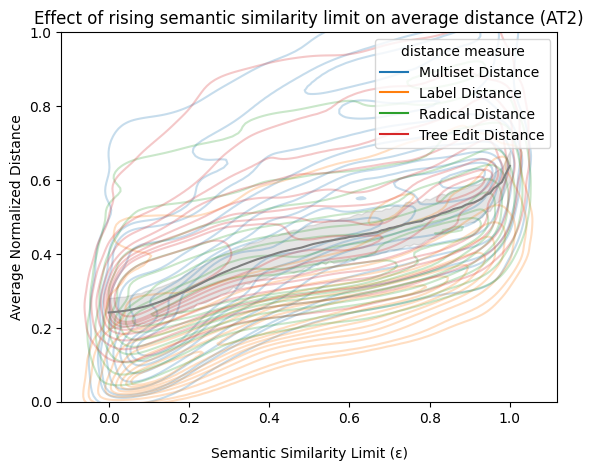

In [33]:
filename = "similaritylimits_at2_scatter"
if percentage:
    filename += "_percentage"

point_size = 5

# sns.scatterplot(at2scatterdata, x="limit", y ="average distance", hue="distance measure", s=2, alpha = .25)
sns.kdeplot(data=at2scatterdata, x="limit", y ="average distance", hue="distance measure", fill=False, common_norm=False, multiple="fill", alpha=.25, linewidth=0)
sns.lineplot(data=fullLine, x="limit", y="average distance", color="gray")
# sns.scatterplot(at2sd1, x="limit", y ="average distance", label = "Tree Edit Distance", s=point_size)
# sns.scatterplot(at2sd2, x="limit", y ="average distance", label = "Label Distance",     s=point_size)
# sns.scatterplot(at2sd3, x="limit", y ="average distance", label = "Radical Distance",   s=point_size)
# sns.scatterplot(at2sd4, x="limit", y ="average distance", label = "Multiset Distance",  s=point_size)

# sns.lineplot(ld2, x="limit", y ="average distance", label = "all-mpnet-base-v2")
# sns.lineplot(ld3, x="limit", y ="average distance", label = "all-MiniLM-L12-v2")
# sns.lineplot(ld4, x="limit", y ="average distance", label = "Normalized Levenshtein")
# sns.lineplot(sldf, x="limit", y ="average distance", label = "Traditional Edit Distance")

plt.xlabel("\nSemantic Similarity Limit (ε)")
if percentage:
    plt.ylim(0, 1)
    plt.ylabel("Average Normalized Distance")
else:
    plt.ylabel("Average Distance")
# plt.xticks(fontsize=8, rotation=90)
plt.title("Effect of rising semantic similarity limit on average distance (AT2)")    

plt.savefig(file_preamble + "img/"+filename+".pdf", bbox_inches='tight')